Author: Ryan Inghiterra - DSE210 - Worksheet 8 - Problem 4   
Handwritten digit recognition using a Gaussian generative model

In [592]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999

In [3]:
from struct import unpack
import numpy as np
import matplotlib.pylab as plt 

def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [4]:
x,y = loadmnist('train-images-idx3-ubyte', 'train-labels-idx1-ubyte')

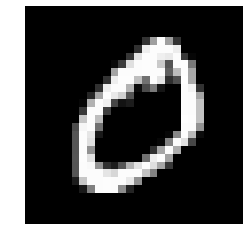

In [5]:
displaychar(x[1])

x is a 60,000 by 784 array where each row corresponds to an image and y to a length-60,000 array where each entry is a label (0-9)

b) split training set into two pieces - training set of 50000 and a separate validation set of size 10,000. Also load in the test data

In [8]:
print(x.shape)
print(y.shape)

(60000, 784)
(60000,)


In [9]:
df = pd.DataFrame(x)
df['label'] = y
print(df.shape)
df = df.sample(frac=1).reset_index(drop=True) #shuffling all 60,000 rows (which have features and labels)
df.head(2)

(60000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [10]:
train_set = df.loc[:49999, :]
print(train_set.shape)

(50000, 785)


In [298]:
valid_set = df.loc[50000:,:].reset_index()
del valid_set['index']
print(valid_set.shape)

(10000, 785)


In [300]:
valid_set.head(4)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7


In [12]:
# Also load in test data
test_x, test_y = loadmnist('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')

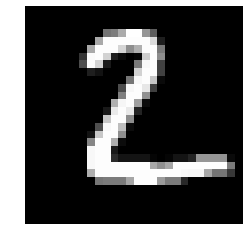

In [13]:
displaychar(test_x[1])

In [14]:
test_set = pd.DataFrame(test_x)
test_set['label'] = test_y
print(test_set.shape)
test_set.head(2)

(10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


(c) Now fit a gaussian generative model to the training data of 50,000 points

determine class probabilities

In [216]:
# determine the class probilities pi_0 .. pi_9 (what fraction of training points are 0's for instance)
pi_probs = train_set.groupby('label').count().iloc[:,0] / 50000
pi_probs_dic = pi_probs.to_dict()
pi_probs_dic

{0: 0.099479999999999999,
 1: 0.1129,
 2: 0.099239999999999995,
 3: 0.10198,
 4: 0.097379999999999994,
 5: 0.089639999999999997,
 6: 0.098360000000000003,
 7: 0.10444000000000001,
 8: 0.097199999999999995,
 9: 0.099379999999999996}

 Fit a Gaussian to each digit by finding mean and the covariance of the corresponding data points
Let the Gaussian for the jth digit be Pj = N(mean(j), cov_matrix(j))

In [547]:
# first lets calculate the means for each digit
train_means = train_set.groupby('label').mean() # each digit has a mean in 784 dimensions (each row)
train_means.head(2)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
label,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [548]:
mean_dic = train_means.to_dict(orient='index') 
# now we have a dictionary where key is the label and value is the mean array

In [549]:
cov_matrix_dic = {}
# want to calculate covariance matrix. where it should be 784X784 matrix since there are 784 features (pixels)
for i in range(0, 10):
    sub_df = train_set[train_set['label'] == i]
    sub_df.set_index('label', inplace=True)
    #print("df shape: {0}".format(sub_df.shape))
    cov_matrix = np.cov(sub_df, rowvar=False)
    #print("cov_matrix shape: {0} ".format(cov_matrix.shape))
    cov_matrix_dic[i] = cov_matrix

so now we have a dictionary where each label 0-9 is the key and value for each is the cov. matrix (784X784)
we also have a dictionary where each label 0-9 is the key and the value for each is the mean (784 dimensions)

now lets calculate the P_j(x) functions for each digit and store them in a dictionary

In [550]:
# these are all the Pj(x) functions stored in a dictionary, one for each digit 1-9
normal_func_dic = {}
for i in range(10):
    mean_array = mean_dic[i].values()
    cov_matrix = cov_matrix_dic[i]
    normal_func = stats.multivariate_normal(mean = mean_array, cov = cov_matrix, allow_singular=True)
    normal_func_dic[i] = normal_func

print(len(normal_func_dic))

10


 what dimensions is p_j(x)* pi_j supposed to have?? so p_j(x) is a single value representing the density .
so for test set of 10 observations, each observation will have 10 different p_0_(x) through p_9_(x) and 
those are multiplied by pi_1 - pi_10 for each digit, then we want the max of those values, for each observation and
we classify to the one with the highest value

Now lets put things all together and create a function that takes in the observations, the class probabilities, and the P_j(x) gaussian functions for each digit and then  does a Baye's rule to classify the observation with a predicted
digit label, (calculated by taking the largest pi_j*p_j(x). 


Since we are using logpdf we need to do log(pi_j) + log(p_j(x)) instead of pi_j*p_j(x)

In [558]:
def get_classification_results(observations, pi_probs_dic, normal_func_dic):
    x = np.array(observations.iloc[:,:-1]) # want to get rid of label colum  before doing calculations
    normal_func_result_list = []

    for i in range(10):
        p_j_x = normal_func_dic[i].logpdf(x) # apply logpdf of the gaussian function to the observations
        # add each val by log(pi_j) since logpdf
        normal_func_result_list.append([ val + np.log(pi_probs_dic[i]) for val in p_j_x])
    # now we have all the different p_j(x) + pi_j, 10 for each observation, we need to pick the max value    
    result_df = pd.DataFrame(normal_func_result_list).transpose()
    predicted_labels = result_df.idxmax(axis=1) # we get the digit that gave the max logpdf(x) + log(pi_j) value as prediction
    final_df = pd.DataFrame(predicted_labels, columns=['predicted_label'])
    final_df['actual_label'] = observations['label']
    return final_df

In [559]:
valid_result_df = get_classification_results(valid_set, pi_probs_dic, normal_func_dic)

In [560]:
print(valid_result_df.shape)
valid_result_df.head(3)

(10000, 2)


,predicted_label,actual_label
0,2,2
1,3,3
2,0,0


now lets compute the predicted vs actual to see how good the classifier was

In [561]:
# dataframe should have a predicted_label and actual_label column
def classifier_accuracy(df):
    num_of_correct = 0
    for i in range(len(df)):
        predicted = df.loc[i,'predicted_label']
        actual = df.loc[i,'actual_label']
        if (predicted == actual):
            num_of_correct += 1

    predict_accuracy = (float(num_of_correct) / len(df)) * 100
    return predict_accuracy

In [562]:
valid_set_score = classifier_accuracy(valid_result_df)
print("validation set prediction score: {0}".format(valid_set_score))

validation set prediction score: 81.14


so on our validation set of 10,000 observation our classifier correctly classified 81.14 % of the observations
(or you can see a percent error of 18.86 %)

(d) One last step is needed: it is important to smooth the covariance matrices, and the usual way to
do this is to add in cI, where c is some constant and I is the identity matrix. What value of c
is right? Use the validation set to help you choose. That is, choose the value of c for which the
resulting classifier makes the fewest mistakes on the validation set. What value of c did you get?

In [563]:
identity_matrix = np.eye(784)
best_c = 0
best_predict_score = 0
for c in range(1000,3000,100):
    ci_matrix = c * identity_matrix #cI matrix
    # these are all the Pj(x) functions stored in a dictionary, one for each digit 1-9
    normal_func_dic = {}
    for i in range(10):
        mean_array = mean_dic[i].values()
        cov_matrix = cov_matrix_dic[i] + ci_matrix
        normal_func = stats.multivariate_normal(mean = mean_array, cov = cov_matrix, allow_singular=True)
        normal_func_dic[i] = normal_func
        
    valid_result_df = get_classification_results(valid_set, pi_probs_dic, normal_func_dic)
    valid_set_score = classifier_accuracy(valid_result_df)
    if (valid_set_score > best_predict_score):
        best_predict_score = valid_set_score
        best_c = c
print(best_c, best_predict_score)   

(2800, 95.38)


iterating through some different values of c, I got a value of 2800 for c gave the best prediction score of 95.38 %, or in other words misclassified 4.62 % of the digit labels

(e)
1. Error rate on the MNIST test set.


In [564]:
c = 2800
identity_matrix = np.eye(784)
ci_matrix = c * identity_matrix #cI matrix
normal_func_dic = {}
for i in range(10):
    mean_array = mean_dic[i].values()
    cov_matrix = cov_matrix_dic[i] + ci_matrix
    normal_func = stats.multivariate_normal(mean = mean_array, cov = cov_matrix, allow_singular=True)
    normal_func_dic[i] = normal_func
test_result_df = get_classification_results(test_set, pi_probs_dic, normal_func_dic)
test_set_score = classifier_accuracy(test_result_df)
print("test set prediction score: {0}".format(test_set_score))

test set prediction score: 95.71


so on our test set of 10,000 observation our classifier correctly classified 95.71 % of the observations
(or you can see an error rate of **4.29 %**)

2. Out of the misclassified test digits, pick five at random and display them. For each instance,
list the posterior probabilities Pr(y|x) of each of the ten classes.

In [578]:
miss_class_df = test_result_df[test_result_df['predicted_label'] != test_result_df['actual_label']]
miss_class_df = miss_class_df.sample(5) # get a random sample of 5 missclassified
miss_class_df

,predicted_label,actual_label
3943,5,3
3117,9,5
1717,0,8
4152,1,5
1412,1,2


In [585]:
index_list = miss_class_df.index.values
miss_class_fin_df = test_set.iloc[index_list,:]
miss_class_fin_df = miss_class_fin_df.join(miss_class_df)
miss_class_fin_df

,0,1,2,3,4,5,6,7,8,9,...,777,778,779,780,781,782,783,label,predicted_label,actual_label
3943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,5,3
3117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,9,5
1717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,8
4152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,1,5
1412,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,2


**Note** - we are calculating the posterior probabilities below as logpdf(x)  + log(digit_prob)

In [586]:
observations = miss_class_fin_df.iloc[:,:-3]
x = np.array(observations)
df_list = []
# loop through and use the gaussian distribution function for each digit and multiply by pi_probs value
for i in range(10):
    p_j_x = normal_func_dic[i].logpdf(x) # apply logpdf of the gaussian function to the observations
    posterior_prob = p_j_x + np.log(pi_probs[i]) # we are using logpdf(x) + log(digit_prob)
    df_list.append(pd.DataFrame(posterior_prob))
post_probs_df = pd.concat(df_list, axis=1)
post_probs_df.columns = [ "post_prob_"  + str(x) for x in range(10)]
post_probs_df

,post_prob_0,post_prob_1,post_prob_2,post_prob_3,post_prob_4,post_prob_5,post_prob_6,post_prob_7,post_prob_8,post_prob_9
0,-4110.928803,-4188.972417,-4084.041560,-4010.074176,-4076.615213,-4009.526880,-4099.355812,-4166.506101,-4023.585954,-4091.878497
1,-4119.707963,-4129.186216,-4130.634131,-4054.125371,-4061.717785,-4039.315060,-4102.816811,-4060.918540,-4059.725157,-4027.032194
2,-4046.459739,-4382.712858,-4135.751878,-4084.897229,-4229.002800,-4087.350942,-4098.972865,-4260.179114,-4094.780260,-4173.420434
3,-4095.676908,-4016.301821,-4073.694551,-4076.473490,-4083.847210,-4024.691880,-4093.941763,-4080.036463,-4034.455373,-4079.980782
4,-4125.026027,-4028.971019,-4035.772529,-4083.918345,-4099.167062,-4128.823923,-4111.690539,-4124.895473,-4064.347301,-4116.473218


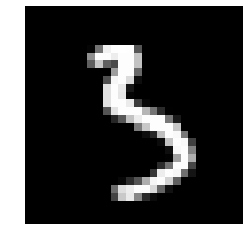

predicted: 5, actual: 3
posterior probabilities Pr(y|x):
post_prob_0   -4110.928803
post_prob_1   -4188.972417
post_prob_2   -4084.041560
post_prob_3   -4010.074176
post_prob_4   -4076.615213
post_prob_5   -4009.526880
post_prob_6   -4099.355812
post_prob_7   -4166.506101
post_prob_8   -4023.585954
post_prob_9   -4091.878497
Name: 0, dtype: float64


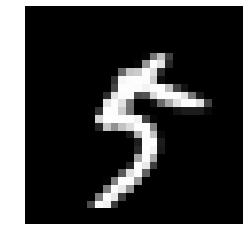

predicted: 9, actual: 5
posterior probabilities Pr(y|x):
post_prob_0   -4119.707963
post_prob_1   -4129.186216
post_prob_2   -4130.634131
post_prob_3   -4054.125371
post_prob_4   -4061.717785
post_prob_5   -4039.315060
post_prob_6   -4102.816811
post_prob_7   -4060.918540
post_prob_8   -4059.725157
post_prob_9   -4027.032194
Name: 1, dtype: float64


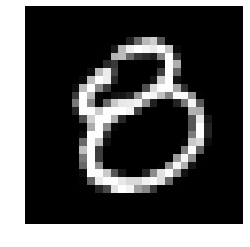

predicted: 0, actual: 8
posterior probabilities Pr(y|x):
post_prob_0   -4046.459739
post_prob_1   -4382.712858
post_prob_2   -4135.751878
post_prob_3   -4084.897229
post_prob_4   -4229.002800
post_prob_5   -4087.350942
post_prob_6   -4098.972865
post_prob_7   -4260.179114
post_prob_8   -4094.780260
post_prob_9   -4173.420434
Name: 2, dtype: float64


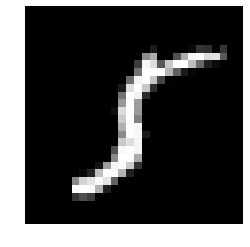

predicted: 1, actual: 5
posterior probabilities Pr(y|x):
post_prob_0   -4095.676908
post_prob_1   -4016.301821
post_prob_2   -4073.694551
post_prob_3   -4076.473490
post_prob_4   -4083.847210
post_prob_5   -4024.691880
post_prob_6   -4093.941763
post_prob_7   -4080.036463
post_prob_8   -4034.455373
post_prob_9   -4079.980782
Name: 3, dtype: float64


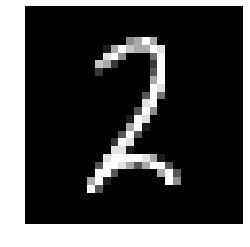

predicted: 1, actual: 2
posterior probabilities Pr(y|x):
post_prob_0   -4125.026027
post_prob_1   -4028.971019
post_prob_2   -4035.772529
post_prob_3   -4083.918345
post_prob_4   -4099.167062
post_prob_5   -4128.823923
post_prob_6   -4111.690539
post_prob_7   -4124.895473
post_prob_8   -4064.347301
post_prob_9   -4116.473218
Name: 4, dtype: float64


In [591]:
for i in range(5):
    displaychar(np.array(miss_class_fin_df.iloc[i,:-3]))
    predicted = miss_class_fin_df.iloc[i,-2]
    actual = miss_class_fin_df.iloc[i,-1]
    print("predicted: {0}, actual: {1}".format(predicted, actual))
    print("posterior probabilities Pr(y|x):")
    print(post_probs_df.iloc[i])